In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

DATA COLLECTION

1. Datos de Yahoo Finance

In [62]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Gold no existe. El ticker no baja ninguna información. Lo sustituyo por la volatilidad del mercado de oro que se descarga de los datos de la FED de St. Louis.

Para el Sp500 utilizo los datos a partir del año 2000, ya que en años anteriores la composición por industria del SP500 era bastante diferente. A partir de ese año hay importnate participación del sector teconología. Hago lo mismo para las otras variables

In [63]:
start_date = '2000-01-01'
end_date = '2024-04-30'

sp500 = sp500.history(period="max")
sp500 =sp500.loc[start_date:end_date].copy ()
oil = oil.history(period="max")
oil = oil.loc[start_date:end_date].copy ()
brent = brent.history(period="max") 
brent = brent.loc[start_date:end_date:].copy ()


In [64]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [65]:
#Remueve las columans que no necesito
sp500 = sp500.drop(columns=['Dividends', 'Stock Splits'])
sp500.index= sp500.index.tz_localize(None) # remove timezone porque tengo otras variables que no la tienen. para uniformar

In [66]:
#Guarda el dataset en un archivo csv   
sp500.to_csv('sp500.csv', index=True)

In [67]:
#Hace lo mismo con el oil
oil = oil.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
oil.index= oil.index.tz_localize(None) # remove timezone
oil.head()

,Close
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


In [68]:
# Renombr< la columna 'Close' a 'Close_oil' en el DataFrame 'oil' para que no se confunda con la del S&P 500
oil.rename(columns={'Close': 'Close_oil'}, inplace=True)

# Muestra las primeras filas para verificar el cambio
print(oil.head())


            Close_oil
Date                 
2000-08-23  32.049999
2000-08-24  31.629999
2000-08-25  32.049999
2000-08-28  32.869999
2000-08-29  32.720001


2. Datos de FRED (Banco de la Reserva Federal de St. Louis) -

Información económica diaria y que refleja expectativas del mercado. Como no existen variables fundamentales diarias relacionadas con el índice, 
incluyo variables diarias del mercado que reflejen el sentimiento de la evolución de la economía, lo cual afecta consecuentemente la evolución de las empresas y su valor.
Las variables macro y las fundamentales en general no suelen ser diarias.

In [69]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES # OJO --->>>> Estas variables miden el riesgo de crédito y el apetito por el riesgo de los inversores 

# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
#OJO --->>>> Esta variables miden el cambio en las expectativas de inflación y los movimientos de tasas de interés

# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.
#(GVZCLS)= CBOE Gold ETF Volatility Index 

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS','GVZCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




3. Uno los dataframes

In [70]:
# Unir macroeconomic_df con sp500 basado en sus índices de fecha
AllVar_df =sp500.join(macroeconomic_df, how='inner')

print(AllVar_df.index)
AllVar_df = AllVar_df.sort_index()

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='Date', length=6120, freq=None)


In [71]:
# Unir el DataFrame 'oil' al 'AllVar_df' que ya contiene datos combinados de 'macroeconomic_df' y 'sp500'

if 'Date' in oil.columns:
    oil.set_index('Date', inplace=True)


AllVar_df = AllVar_df.join(oil, how='inner', lsuffix='_AllVar', rsuffix='_oil')

# Mostrar las primeras filas para verificar las nuevas columnas
print(AllVar_df.head())

                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  T10Y2Y  T10Y3M  \
Date                                                  ...                   
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   -0.47   -0.56   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   -0.46   -0.56   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   -0.46   -0.58   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   -0.45   -0.54  

4. Calculo variables análisis técnico y  cambios diarios

Calculo de las variables para análisis técnico (variables calculadas a partir del valor del índice). 
Buscan determinar tendencias en los precios.

Medias moviles (dias hábiles)

In [72]:
#Calculo la media 
# Periodos para las medias móviles
moving_avg_periods = [5,10, 20,200]

# Calcular y asignar cada media móvil utilizando un bucle
for period in moving_avg_periods:
    AllVar_df[f'{period}d_moving_avg'] = AllVar_df['Close'].rolling(window=period).mean()

# Mostrar las primeras filas para verificar las nuevas columnas
AllVar_df.head()



,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,DEXCHUS,DEXCAUS,DEXMXUS,VIXCLS,GVZCLS,Close_oil,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,8.2793,1.4877,9.2725,17.38,NaN,32.049999,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,8.2799,1.4871,9.2440,17.04,NaN,31.629999,NaN,NaN,NaN,NaN
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,8.2799,1.4828,9.2320,16.53,NaN,32.049999,NaN,NaN,NaN,NaN
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,8.2799,1.4845,9.2130,16.54,NaN,32.869999,NaN,NaN,NaN,NaN
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,8.2799,1.4868,9.2325,16.89,NaN,32.720001,1508.931982,NaN,NaN,NaN


Media movil ultimos 10 días hábiles

In [73]:
#Calculo el promedio móvil ponderado de los ultimas 2 semanas

# Definimos los pesos decrecientes para los últimos 10 días hábiles.
weights = np.arange(1, 11)[::-1]  # Esto crea un array de numpy: [10, 9, ..., 2, 1]

# Calculamos el WMA para cada ventana de 10 días hábiles.
# Usamos apply para aplicar una función personalizada que calcula el WMA de manera vectorizada.
AllVar_df['10d_wma'] = AllVar_df['Close'].rolling(window=10).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Ahora, el DataFrame 'AllVar_df' contiene una nueva columna '10d_wma' con el WMA de 10 días.
# Muestra los primeros registros para verificar.
print(AllVar_df[['Close', '10d_wma']].head(20))


                  Close      10d_wma
Date                                
2000-08-23  1505.969971          NaN
2000-08-24  1508.310059          NaN
2000-08-25  1506.449951          NaN
2000-08-28  1514.089966          NaN
2000-08-29  1509.839966          NaN
2000-08-30  1502.589966          NaN
2000-08-31  1517.680054          NaN
2000-09-01  1520.770020          NaN
2000-09-05  1507.079956          NaN
2000-09-06  1492.250000  1509.020898
2000-09-07  1502.510010  1509.418539
2000-09-08  1494.500000  1509.139617
2000-09-11  1489.260010  1508.886353
2000-09-12  1481.989990  1506.660358
2000-09-13  1484.910034  1504.753820
2000-09-14  1480.869995  1503.770554
2000-09-15  1465.810059  1499.100546
2000-09-18  1444.510010  1492.482180
2000-09-19  1459.900024  1487.495099
2000-09-20  1451.339966  1484.460556


Momentum

In [74]:
# Calcular el momentum como el cambio día a día en la columna 'Close'. Es lo mismo que el daily change pero en absoluto no porcentual
AllVar_df['Momentum'] = AllVar_df['Close'].diff()

print(AllVar_df.head())  # Mostrar las primeras filas para verificar la nueva columna

                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  DEXMXUS  VIXCLS  \
Date                                                  ...                    
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   9.2725   17.38   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   9.2440   17.04   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   9.2320   16.53   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   9.2130   1

Stochastic %K

El Stochastic %K es una medida de la posición relativa del precio de cierre actual en relación con el rango alto-bajo durante un número específico de períodos pasados. La fórmula para calcular el Stochastic %K es la siguiente:

% K = [(C-LLn)/(HHn-LLn)]x 100� 

donde:


C es el precio de cierre más reciente,

LLn es el precio más bajo de los prcios bajos (Low) en los últimos n períodos,
Hn  es el precio más alto de lso pecios altos (High) en los últimos n períodos,
n es el número de períodos utilizados para el cálculo.
El valor de n varía según el análisis, pero los valores comunes incluyen 14, 20 o cualquier otro valor dependiendo de la estrategia de trading

In [75]:
# Calcular el Stochastic %K para cada fila basado en los 20 días laborables previos



# Crea una función para encapsular el cálculo del Stochastic %K
def calculate_stochastic_k(row_index, df):
    if row_index < 19:  # Asegurar que haya suficientes datos para los primeros 19 registros
        return None
    else:
        # Seleccionar los últimos 20 registros hasta el índice actual para las columnas 'High' y 'Low'
        high_period = df['High'][row_index-19:row_index+1]
        low_period = df['Low'][row_index-19:row_index+1]
        low_20 = low_period.min()
        high_20 = high_period.max()
        close_recent = df['Close'].iloc[row_index]
        
        # Calcular el Stochastic %K
        stochastic_k = ((close_recent - low_20) / (high_20 - low_20)) * 100
        return stochastic_k

# Aplica la función a cada fila
AllVar_df['Stochastic_%K'] = [calculate_stochastic_k(i, AllVar_df) for i in range(len(AllVar_df))]

# Muestra las últimas filas para verificar la nueva columna
print(AllVar_df.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  VIXCLS  GVZCLS  \
Date                                                  ...                   
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...   15.97   17.45   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...   15.37   17.32   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...   15.03   16.92   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...   14.67   

Stochastic %D

El indicador Stochastic %D es una media móvil del indicador Stochastic %K. Usualmente se calcula como la media móvil simple de los últimos 3 valores de %K. 

In [76]:

# Calcular el Stochastic %D como la media móvil simple de 3 días de %K
AllVar_df['Stochastic_%D'] = AllVar_df['Stochastic_%K'].rolling(window=3).mean()

last_20_stochastic_D = AllVar_df['Stochastic_%D'][-20:]

print(last_20_stochastic_D)
AllVar_df.head(9)

Date
2024-04-03    76.922842
2024-04-04    57.726515
2024-04-05    55.575326
2024-04-08    53.829101
2024-04-09    64.992990
2024-04-10    54.961573
2024-04-11    53.283501
2024-04-12    35.318808
2024-04-15    25.095684
2024-04-16     7.141325
2024-04-17     5.118661
2024-04-18     4.821237
2024-04-19     4.569616
2024-04-22     8.741723
2024-04-23    20.099123
2024-04-24    31.278398
2024-04-25    35.328193
2024-04-26    38.522920
2024-04-29    43.766969
2024-04-30    42.643557
Name: Stochastic_%D, dtype: float64


,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,GVZCLS,Close_oil,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,32.049999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,NaN,31.629999,NaN,NaN,NaN,NaN,NaN,2.340088,NaN,NaN
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,NaN,32.049999,NaN,NaN,NaN,NaN,NaN,-1.860107,NaN,NaN
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,NaN,32.869999,NaN,NaN,NaN,NaN,NaN,7.640015,NaN,NaN
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,NaN,32.720001,1508.931982,NaN,NaN,NaN,NaN,-4.250000,NaN,NaN
2000-08-30,1509.839966,1510.489990,1500.089966,1502.589966,818400000,7.58,1.77,8.30,2.49,6.28,...,NaN,33.400002,1508.255981,NaN,NaN,NaN,NaN,-7.250000,NaN,NaN
2000-08-31,1502.589966,1525.209961,1502.589966,1517.680054,1056600000,7.52,1.79,8.24,2.51,6.43,...,NaN,33.099998,1510.129980,NaN,NaN,NaN,NaN,15.090088,NaN,NaN
2000-09-01,1517.680054,1530.089966,1515.530029,1520.770020,767700000,7.51,1.83,8.22,2.54,6.48,...,NaN,33.380001,1512.993994,NaN,NaN,NaN,NaN,3.089966,NaN,NaN
2000-09-05,1520.770020,1520.770020,1504.209961,1507.079956,838500000,7.51,1.82,8.22,2.53,6.41,...,NaN,33.799999,1511.591992,NaN,NaN,NaN,NaN,-13.690063,NaN,NaN


El Índice de Fuerza Relativa

El Índice de Fuerza Relativa (RSI, por sus siglas en inglés) es un indicador de momento que mide la magnitud de los movimientos recientes de precios para evaluar condiciones de sobrecompra o sobreventa en el precio de un activo. Se calcula utilizando la fórmula:

RSI=100− 100/(1+RS)
 

donde 
�
�
RS es la relación media de días de cierre hacia arriba entre la media de días de cierre hacia abajo. Para calcularlo para los últimos 20 y 10 días, necesitamos seguir los siguientes pasos para cada ventana de tiempo:

Calcular los cambios diarios en el precio de cierre.
Separar estos cambios en ganancias (aumentos) y pérdidas (disminuciones).
Calcular el promedio de ganancias y el promedio de pérdidas sobre el período de interés (20 días y 10 días, respectivamente).
Calcular el RS, que es el promedio de ganancias dividido por el promedio de pérdidas.
Utilizar la fórmula del RSI para obtener el valor final.

In [77]:
# Separar las ganancias (positivas) de las pérdidas (negativas)
gain = AllVar_df['Momentum'].mask(AllVar_df['Momentum'] > 0, 0)
loss = -AllVar_df['Momentum'].mask(AllVar_df['Momentum'] < 0, 0)

# Calcular el RSI para los últimos 20 y 10 días
window_lengths = [20, 10]

for length in window_lengths:
    # Calcular el promedio de ganancias y pérdidas
    avg_gain = gain.rolling(window=length, min_periods=1).mean()
    avg_loss = loss.rolling(window=length, min_periods=1).mean()
    
    # Calcular RS
    rs = avg_gain / avg_loss
    
    # Calcular RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Adjuntar al DataFrame
    AllVar_df[f'RSI_{length}'] = rsi

# Mostrar las últimas 20 filas para verificar las nuevas columnas
print(AllVar_df.tail(20))



                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-03  5194.370117  5228.750000  5194.370117  5211.490234  3703250000   
2024-04-04  5244.049805  5256.589844  5146.060059  5147.209961  4075680000   
2024-04-05  5158.950195  5222.180176  5157.209961  5204.339844  3386780000   
2024-04-08  5211.370117  5219.569824  5197.350098  5202.390137  3278180000   
2024-04-09  5217.029785  5224.810059  5160.779785  5209.910156  3400680000   
2024-04-10  5167.879883  5178.430176  5138.700195  5160.640137  3845930000   
2024-04-11  5172.950195  5211.779785  5138.770020  5199.060059  3509380000   
2024-04-12  5171.509766  5175.029785  5107.939941  5123.410156  3963220000   
2024-04-15  5149.669922  5168.430176  5052.470215  5061.819824  3950210000   
2024-04-16  5064.589844  5079.839844  5039.830078  5051.410156  4006200000   
2024-04-17  5068.970215  5077.959961  5007.250000  5022.209961  

Indicador Larry Williams %R

El indicador Larry Williams %R es una medida de momentum que se utiliza para identificar niveles de sobrecompra y sobreventa en un mercado. Se calcula como un porcentaje que refleja la posición del precio de cierre relativo a su rango más alto y más bajo durante un número específico de períodos pasados. La fórmula del Larry Williams %R es:

%R= [(Hn-C)/(Hn-Ln)]x100

donde:

C es el precio de cierre actual,
Hn  es el precio más alto en los últimos n períodos,
Ln es el precio más bajo en los últimos 
�
n períodos,
�
n es el número de períodos utilizados para el cálculo.
Generalmente, se utiliza un período de 14 días para el cálculo de este indicador, pero se puede ajustar según las necesidades del análisis. Para agregar el Larry Williams %R al DataFrame sp500 para los últimos 14 días, puedes usar el siguiente código:

In [78]:
# Asumiendo que sp500 es tu DataFrame y tiene columnas 'High', 'Low', y 'Close' con los precios más altos, más bajos y de cierre

# Configurar el número de períodos para el cálculo de Williams %R
n = 10

# Calcular el precio más alto y el más bajo de los últimos n días
high_n = AllVar_df['High'].rolling(window=n).max()
low_n = AllVar_df['Low'].rolling(window=n).min()

# Calcular el Williams %R
AllVar_df['Williams_%R'] = ((high_n - AllVar_df['Close']) / (high_n - low_n)) * -100

# Mostrar las últimas filas para verificar la nueva columna
print(AllVar_df.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  10d_moving_avg  \
Date                                                  ...                   
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...     5058.904004   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...     5043.839990   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...     5041.494971   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...     5046.9

Moving Average Convergence/Divergence Oscillator

The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one. As a result, the MACD offers the best of both worlds: trend following and momentum. T

In [79]:
#https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd


# Calcular las EMAs de 12 y 26 períodos para la columna 'Close'
ema12 = AllVar_df['Close'].ewm(span=12, adjust=False).mean()
ema26 = AllVar_df['Close'].ewm(span=26, adjust=False).mean()

# Calcular el MACD restando la EMA de 26 períodos de la EMA de 12 períodos
AllVar_df['MACD'] = ema12 - ema26

# Calcular la línea de señal como la EMA de 9 períodos del MACD
AllVar_df['Signal_Line'] = AllVar_df['MACD'].ewm(span=9, adjust=False).mean()

# Mostrar las últimas filas para verificar las nuevas columnas
print(AllVar_df.tail())
AllVar_df.head()


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  200d_moving_avg  \
Date                                                  ...                    
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...      4683.744802   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...      4686.790603   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...      4689.929602   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...      

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D,RSI_20,RSI_10,Williams_%R,MACD,Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,NaN,NaN,2.340088,NaN,NaN,0.000000,0.000000,NaN,0.186674,0.037335
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,NaN,NaN,-1.860107,NaN,NaN,44.286213,44.286213,NaN,0.182416,0.066351
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,NaN,NaN,7.640015,NaN,NaN,15.710088,15.710088,NaN,0.786461,0.210373
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,NaN,NaN,-4.250000,NaN,NaN,37.974069,37.974069,NaN,0.911722,0.350643


Cambios diarios en las variables alternativas fundamentales
Trabajo con daily changes y no números absolutos porque ARIMA y modelos en general trabajan mejor con series estacionarias. Para observaciones diarias, los cambios diarios son una forma común de estacionarizar la serie temporal.

In [80]:
# Calcular los retornos diarios 
retornos_diarios = AllVar_df[['Close']].pct_change()

# Multiplicar por 100 para obtener porcentajes
retornos_diarios = retornos_diarios * 100

# Añadir la columna de retornos diarios al DataFrame original
# Nombrando la columna como 'Retornos Diarios'
AllVar_df['Daily Returns'] = retornos_diarios




In [81]:
columns_to_change = [
    'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 
    'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 
    'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS'
]
for column in columns_to_change:
    new_column_name = f'{column}_daily_change'
    AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100

print(AllVar_df.head())


                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  \
Date                                                  ...   
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   
2000-08-29  7.58    1.77  8.30    2.49          6.30  ...   

            BAMLHE00EHYIOAS_dail

C:\Users\lgarn\AppData\Local\Temp\ipykernel_18072\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100
C:\Users\lgarn\AppData\Local\Temp\ipykernel_18072\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100
C:\Users\lgarn\AppData\Local\Temp\ipykernel_18072\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to callin

In [82]:
# Calcula los cambios diarios en el precio del oil.
AllVar_df['oil_daily_changes'] = AllVar_df['Close_oil'].pct_change() * 100  # Multiplicar por 100 para convertir a porcentaje


In [83]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y2Y_daily_change,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,-2.127660,0.000000,NaN,0.680272,0.007247,-0.040331,-0.307360,-1.956272,NaN,-1.310453
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,0.000000,3.571429,NaN,-0.044307,0.000000,-0.289153,-0.129814,-2.992958,NaN,1.327854
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,-2.173913,-6.896552,NaN,-0.243794,0.000000,0.114648,-0.205806,0.060496,NaN,2.558501
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,0.000000,-7.407407,NaN,-0.399911,0.000000,0.154934,0.211657,2.116082,NaN,-0.456336


In [84]:
# Contar los valores nulos en cada columna
null_counts_All = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna antes de limpiar:\n", null_counts_All)

# Reemplazar los valores infinitos por NaN
AllVar_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar las filas con valores nulos o NaN
AllVar_df = AllVar_df.dropna()

# Contar de nuevo los valores nulos en cada columna
null_counts_clean = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna después de limpiar:\n", null_counts_clean)




Conteo de valores nulos por columna antes de limpiar:
 Open                               0
High                               0
Low                                0
Close                              0
Volume                             0
DAAA                              39
AAA10Y                            44
DBAA                              39
BAA10Y                            44
BAMLH0A0HYM2                       2
BAMLH0A2HYB                        2
BAMLH0A3HYC                        2
BAMLHE00EHYIOAS                    2
T10Y2Y                            42
T10Y3M                            42
T5YIE                            622
DEXUSEU                           53
DEXCHUS                           53
DEXCAUS                           53
DEXMXUS                           53
VIXCLS                             0
GVZCLS                          1940
Close_oil                          0
5d_moving_avg                      4
10d_moving_avg                     9
20d_moving_avg      

IMPORTANTE: cuando se unen todas las variables en AllVar_df, se cambia año de inicio al 2008 porque es cuando hay datos para todas.

In [85]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y2Y_daily_change,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-04,1376.260010,1388.180054,1371.739990,1377.199951,4338640000,5.64,1.66,7.02,3.04,6.79,...,2.721088,3.381643,-1.694915,-0.006471,0.421107,0.935230,0.291545,2.766798,-0.873744,-1.616921
2008-06-05,1377.479980,1404.050049,1377.479980,1404.050049,4350790000,5.69,1.63,7.07,3.01,6.63,...,1.986755,3.271028,2.155172,0.692422,-0.248445,0.492854,-0.077519,-10.432692,0.396651,4.488960
2008-06-06,1400.060059,1400.060059,1359.900024,1360.680054,4771660000,5.61,1.67,6.98,3.04,6.68,...,0.000000,-5.429864,3.375527,1.098972,-0.331126,-0.078470,0.543057,26.462695,3.599649,8.412233
2008-06-09,1360.829956,1370.630005,1350.619995,1361.760010,4404570000,5.58,1.56,6.96,2.94,6.58,...,-16.233766,1.913876,1.224490,-0.082639,0.000000,0.353392,-0.038580,-1.867572,3.686441,-3.024388
2008-06-10,1358.979980,1366.839966,1351.560059,1358.439941,4635070000,5.66,1.55,7.05,2.94,6.49,...,-6.976744,-1.877934,0.000000,-1.558722,0.026000,0.176074,0.231571,0.259516,3.759706,-2.262753


In [86]:
# Crear un "lag" de 1 día para los retornos diarios
AllVar_df['Lag 1_Returns'] = AllVar_df['Daily Returns'].shift(+1)
AllVar_df['Lag 2_Returns'] = AllVar_df['Daily Returns'].shift(+2)
AllVar_df['Next_Day_Returns'] = AllVar_df['Daily Returns'].shift(-1)

# Crear la columna 'TARGET' basada en 'Lagged_Daily_Returns' - Quiero predecir si el retorno del día siguiente será positivo o negativo basado con respecto al día actual en el que tomo la decision al final del día
AllVar_df['TARGET'] = np.where(AllVar_df['Next_Day_Returns'] > 0, 1, 0)

# Mostrar las primeras filas para verificar las nuevas columnas
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes,Lag 1_Returns,Lag 2_Returns,Next_Day_Returns,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-04,1376.260010,1388.180054,1371.739990,1377.199951,4338640000,5.64,1.66,7.02,3.04,6.79,...,0.421107,0.935230,0.291545,2.766798,-0.873744,-1.616921,NaN,NaN,1.949615,1
2008-06-05,1377.479980,1404.050049,1377.479980,1404.050049,4350790000,5.69,1.63,7.07,3.01,6.63,...,-0.248445,0.492854,-0.077519,-10.432692,0.396651,4.488960,-0.032670,NaN,-3.088921,0
2008-06-06,1400.060059,1400.060059,1359.900024,1360.680054,4771660000,5.61,1.67,6.98,3.04,6.68,...,-0.331126,-0.078470,0.543057,26.462695,3.599649,8.412233,1.949615,-0.032670,0.079369,1
2008-06-09,1360.829956,1370.630005,1350.619995,1361.760010,4404570000,5.58,1.56,6.96,2.94,6.58,...,0.000000,0.353392,-0.038580,-1.867572,3.686441,-3.024388,-3.088921,1.949615,-0.243807,0
2008-06-10,1358.979980,1366.839966,1351.560059,1358.439941,4635070000,5.66,1.55,7.05,2.94,6.49,...,0.026000,0.176074,0.231571,0.259516,3.759706,-2.262753,0.079369,-3.088921,-1.689434,0


Variables control

Selecciono el tamaño del periodo de prueba y la fecha de inicio de análisis para el que el periodo de prueba se mantenga como una serie de tiempo en orden histórico.

In [87]:
fecha_inicio = '2014-04-30'
test_size_Control=0.2

In [88]:
# Convertir a datetime
fecha_inicio_1 = pd.to_datetime(fecha_inicio)
end_date_1 = pd.to_datetime(end_date)


# Calcular el total de días
total_dias = (end_date_1 - fecha_inicio_1).days

# Calcular el número de días para el entrenamiento
dias_entrenamiento = int(total_dias * (1 - test_size_Control))

# Calcular la fecha de corte
fecha_corte = fecha_inicio_1 + pd.Timedelta(days=dias_entrenamiento)

print("Fecha de corte para dividir los datos:", fecha_corte)
print("incio:", fecha_inicio)


Fecha de corte para dividir los datos: 2022-04-30 00:00:00
incio: 2014-04-30


In [89]:

AllVar_df_Shortened = AllVar_df.loc[fecha_inicio:]

LSTM

In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical

In [91]:
print(AllVar_df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'DAAA', 'AAA10Y', 'DBAA',
       'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 'BAMLH0A3HYC',
       'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 'DEXCHUS',
       'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS', 'Close_oil', '5d_moving_avg',
       '10d_moving_avg', '20d_moving_avg', '200d_moving_avg', '10d_wma',
       'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI_20', 'RSI_10',
       'Williams_%R', 'MACD', 'Signal_Line', 'Daily Returns',
       'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change',
       'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change',
       'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change',
       'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change',
       'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change',
       'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change',
       'VIXCLS_daily_change', 'GVZCLS_daily_change', 'oil_daily_changes',
       'Lag 1

In [92]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

AllVar_df_Shortened.index = pd.to_datetime(AllVar_df_Shortened.index)


AllVar_df_Shortened['TARGET'].index = AllVar_df_Shortened.index

#From Random F:orest top 20: ['DEXUSEU','DEXMXUS','GVZCLS','RSI_10','Williams_%R','Daily Returns','DAAA_daily_change','DBAA_daily_change','BAMLH0A3HYC_daily_change','T10Y3M_daily_change','T5YIE_daily_change','DEXUSEU_daily_change','DEXCHUS_daily_change','DEXCAUS_daily_change','DEXMXUS_daily_change','VIXCLS_daily_change','GVZCLS_daily_change','Lag 1_Returns','Lag 2_Returns']
#['Volume', 'VIXCLS', 'GVZCLS',  '20d_moving_avg','200d_moving_avg', '10d_wma', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI_20', 'RSI_10', 'Williams_%R', 'MACD', 'Signal_Line', 'Daily Returns', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change','BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change','T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'VIXCLS_daily_change', 'GVZCLS_daily_change', 'oil_daily_changes', 'Lag 1_Returns', 'Lag 2_Returns']

X_LSTM = AllVar_df_Shortened[['Volume', 'VIXCLS', 'GVZCLS',  '20d_moving_avg','200d_moving_avg', '10d_wma', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI_20', 'RSI_10', 'Williams_%R', 'MACD', 'Signal_Line', 'Daily Returns', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change','BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change','T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'VIXCLS_daily_change', 'GVZCLS_daily_change', 'oil_daily_changes', 'Lag 1_Returns', 'Lag 2_Returns']]
Y_LSTM = AllVar_df_Shortened['TARGET']


# Dividir los datos usando la fecha de corte
train_mask_LSTM = X_LSTM.index <= fecha_corte
test_mask_LSTM = X_LSTM.index > fecha_corte

X_train_LSTM = X_LSTM[train_mask_LSTM]
Y_train_LSTM = Y_LSTM[train_mask_LSTM]
X_test_LSTM = X_LSTM[test_mask_LSTM]
Y_test_LSTM = Y_LSTM[test_mask_LSTM]


# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador a los datos de entrenamiento y transformarlos
X_train_scaled_LSTM = scaler.fit_transform(X_train_LSTM)
X_test_scaled_LSTM = scaler.transform(X_test_LSTM)


In [93]:
X_train_LSTM.head()

,Volume,VIXCLS,GVZCLS,20d_moving_avg,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D,RSI_20,...,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes,Lag 1_Returns,Lag 2_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-30,3779230000,13.41,15.52,1863.200500,1775.041602,1870.665654,5.619995,83.924179,75.828069,50.324568,...,0.512821,0.449015,0.020774,-0.063851,-0.243986,-2.188184,1.371653,-1.520538,0.476076,0.323604
2014-05-01,3416740000,13.25,15.15,1862.839502,1776.078702,1872.956190,-0.269897,83.598687,81.556479,51.524745,...,0.000000,-0.021629,0.000000,0.082147,-0.236940,-1.193139,-2.384021,-0.320834,0.299202,0.476076
2014-05-02,3159560000,12.91,14.85,1862.458002,1777.079852,1875.081106,-2.540039,80.535449,82.686105,51.608552,...,-0.510204,-0.021634,0.000000,0.072959,-0.413714,-2.566038,-1.980198,0.341988,-0.014326,0.299202
2014-05-05,2733730000,13.29,15.51,1863.436505,1778.056302,1876.158196,3.520020,91.334384,85.156173,45.490976,...,-1.538462,0.144259,-0.220479,-0.164039,0.073085,2.943455,4.444444,-0.280672,-0.134845,-0.014326
2014-05-06,3327260000,13.80,15.02,1864.570502,1778.934452,1875.627461,-16.940063,69.325719,80.398517,44.698477,...,-0.520833,0.288101,-0.317038,-0.593336,-0.042282,3.837472,-3.159252,0.020101,0.187122,-0.134845


In [94]:
X_test_LSTM.head()

,Volume,VIXCLS,GVZCLS,20d_moving_avg,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D,RSI_20,...,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes,Lag 1_Returns,Lag 2_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02,5163790000,32.34,20.06,4371.771997,4491.886443,4335.985325,23.449707,17.491589,15.809827,68.390073,...,-2.727273,-0.151846,-0.001513,0.640525,0.353652,-3.173653,1.159859,0.458492,-3.628451,2.474690
2022-05-03,4582050000,29.25,19.71,4351.413989,4491.471392,4297.955522,20.100098,21.277344,13.466518,69.481730,...,0.000000,0.104553,0.000000,-0.364794,-0.416034,-9.554731,-1.744766,-2.624317,0.567524,-3.628451
2022-05-04,5136360000,25.42,18.81,4340.166479,4491.356941,4257.531490,124.689941,51.817254,30.195396,60.113308,...,0.934579,0.066464,0.000000,-0.155800,-0.589797,-13.094017,-4.566210,5.272916,0.483713,0.567524
2022-05-05,5077030000,31.20,19.36,4323.452490,4490.297842,4224.582191,-153.299805,18.393128,30.495909,63.683403,...,-0.308642,-0.303634,0.690083,0.249668,0.321369,22.738002,2.923977,0.417405,2.986242,0.483713
2022-05-06,5116940000,30.19,18.71,4304.608984,4489.077141,4211.094052,-23.530273,13.284519,27.831634,65.370544,...,-0.309598,0.618635,0.174344,0.319091,-0.887093,-3.237179,-3.357438,1.394785,-3.564971,2.986242


In [95]:
Y_train_LSTM.head()

Date
2014-04-30    0
2014-05-01    0
2014-05-02    1
2014-05-05    0
2014-05-06    1
Name: TARGET, dtype: int32

In [96]:
Y_test_LSTM.head()

Date
2022-05-02    1
2022-05-03    1
2022-05-04    0
2022-05-05    0
2022-05-06    0
Name: TARGET, dtype: int32

Definición del Modelo LSTM

In [97]:
## Function to define the LSTM arquitecture. Source: King's College London
def model_fn(params):
    # Crear generadores de series temporales
    train_generator = TimeseriesGenerator(X_train_scaled_LSTM, Y_train_LSTM.values,
                                          length=14, batch_size=params["batch_size"])
    val_generator = TimeseriesGenerator(X_test_scaled_LSTM, Y_test_LSTM.values,
                                        length=14, batch_size=params["batch_size"])
    test_generator = TimeseriesGenerator(X_test_scaled_LSTM, Y_test_LSTM.values,
                                         length=14, batch_size=params["batch_size"]
                                    )
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(int(params["lstm_size"]), input_shape=(14, X_train_scaled_LSTM.shape[1]),
                                   return_sequences=True if params["num_layers"] > 1 else False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(params["dropout"]))

    if params["num_layers"] == 2:
        model.add(tf.keras.layers.LSTM(int(params["lstm_size"])))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(params["dropout"]))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(params["learning_rate"]),
                  loss="binary_crossentropy", metrics=["accuracy"])

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
    
    history = model.fit(train_generator, validation_data=val_generator,
                        callbacks=callbacks, epochs=100, verbose=0).history
    
    return (history, model)


Búsqueda Aleatoria de Hiperparámetros

In [98]:
# Set the random seed to get reproducible outcomes, e.g. when running model using six covariates, or only two covariates
tf.random.set_seed(42)
np.random.seed(42)
import random
random.seed(42)

In [99]:
import os
import random

def random_search(model_fn, search_space, n_iter, search_dir):
    results = []
    histories = []
    
    if not os.path.exists(search_dir):
        os.mkdir(search_dir)
    
    best_model_path = os.path.join(search_dir, "best_model.h5")
    results_path = os.path.join(search_dir, "results.csv")
    
    for i in range(n_iter):
        params = {k: v[np.random.randint(len(v))] for k, v in search_space.items()}
        history, model = model_fn(params)
        
        histories.append(history)
        
        epochs = np.argmax(history["val_accuracy"]) + 1
        result = {k: v[epochs - 1] for k, v in history.items()}
        params["epochs"] = epochs
        
        if i == 0:
            best_val_acc = result["val_accuracy"]
            model.save(best_model_path)
        
        if result["val_accuracy"] > best_val_acc:
            best_val_acc = result["val_accuracy"]
            model.save(best_model_path)
        
        result = {**params, **result}
        results.append(result)
        tf.keras.backend.clear_session()
        print(f"iteration {i + 1} – {', '.join(f'{k}:{v:.4g}' for k, v in result.items())}")
    
    best_model = tf.keras.models.load_model(best_model_path)
    results = pd.DataFrame(results)
    results.to_csv(results_path, index=False)
    
    return (results, best_model, histories)



In [100]:
search_space = {
    "lstm_size": np.linspace(20, 200, 5, dtype=int),
    "dropout": np.linspace(0, 0.4, 5),
    "learning_rate": np.linspace(0.004, 0.01, 5),
    "num_layers": [1, 2],
    "batch_size": [16, 32, 64]
}



In [101]:
iterations = 150
results, best_model, all_histories = random_search(model_fn, search_space, iterations, "search_new_v9")


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


iteration 1 – lstm_size:155, dropout:0.4, learning_rate:0.007, num_layers:2, batch_size:16, epochs:2, accuracy:0.5447, loss:0.7326, val_accuracy:0.5197, val_loss:0.7543
iteration 2 – lstm_size:200, dropout:0.1, learning_rate:0.007, num_layers:1, batch_size:64, epochs:3, accuracy:0.5614, loss:0.6981, val_accuracy:0.5114, val_loss:0.7012
iteration 3 – lstm_size:110, dropout:0.4, learning_rate:0.0085, num_layers:2, batch_size:64, epochs:7, accuracy:0.5579, loss:0.6846, val_accuracy:0.5114, val_loss:0.7089


iteration 4 – lstm_size:200, dropout:0.1, learning_rate:0.0085, num_layers:2, batch_size:32, epochs:10, accuracy:0.5482, loss:0.6981, val_accuracy:0.5362, val_loss:0.7205


iteration 5 – lstm_size:65, dropout:0.3, learning_rate:0.01, num_layers:1, batch_size:32, epochs:9, accuracy:0.7102, loss:0.5603, val_accuracy:0.5487, val_loss:0.8517
iteration 6 – lstm_size:200, dropout:0.3, learning_rate:0.004, num_layers:1, batch_size:64, epochs:4, accuracy:0.5873, loss:0.6836, val_accuracy:0.5135, val_loss:0.714
iteration 7 – lstm_size:110, dropout:0.1, learning_rate:0.0085, num_layers:2, batch_size:64, epochs:6, accuracy:0.603, loss:0.6592, val_accuracy:0.5155, val_loss:0.6948
iteration 8 – lstm_size:110, dropout:0.3, learning_rate:0.0085, num_layers:2, batch_size:16, epochs:2, accuracy:0.5574, loss:0.7025, val_accuracy:0.5197, val_loss:0.7337
iteration 9 – lstm_size:110, dropout:0.4, learning_rate:0.007, num_layers:1, batch_size:16, epochs:3, accuracy:0.5665, loss:0.6914, val_accuracy:0.528, val_loss:0.8616
iteration 10 – lstm_size:20, dropout:0.1, learning_rate:0.0085, num_layers:1, batch_size:32, epochs:4, accuracy:0.6619, loss:0.6152, val_accuracy:0.5321, val_

iteration 79 – lstm_size:200, dropout:0.1, learning_rate:0.0055, num_layers:2, batch_size:16, epochs:12, accuracy:0.5543, loss:0.6894, val_accuracy:0.5528, val_loss:0.7272
iteration 80 – lstm_size:155, dropout:0.1, learning_rate:0.007, num_layers:2, batch_size:16, epochs:1, accuracy:0.5168, loss:0.8304, val_accuracy:0.5031, val_loss:0.7174
iteration 81 – lstm_size:20, dropout:0.4, learning_rate:0.0085, num_layers:2, batch_size:16, epochs:3, accuracy:0.5832, loss:0.6795, val_accuracy:0.528, val_loss:0.7378
iteration 82 – lstm_size:155, dropout:0.4, learning_rate:0.0085, num_layers:2, batch_size:64, epochs:6, accuracy:0.5472, loss:0.692, val_accuracy:0.528, val_loss:0.6944
iteration 83 – lstm_size:110, dropout:0.3, learning_rate:0.01, num_layers:2, batch_size:32, epochs:8, accuracy:0.5528, loss:0.6894, val_accuracy:0.5259, val_loss:0.7227
iteration 84 – lstm_size:110, dropout:0, learning_rate:0.007, num_layers:2, batch_size:32, epochs:5, accuracy:0.5848, loss:0.6721, val_accuracy:0.5342,

iteration 150 – lstm_size:20, dropout:0.1, learning_rate:0.004, num_layers:1, batch_size:64, epochs:6, accuracy:0.6604, loss:0.6071, val_accuracy:0.5404, val_loss:0.7133


In [102]:
# Sort the results by validation accuracy in descending order
sorted_results = results.sort_values("val_accuracy", ascending=False)

# Extract the best batch_size as it is needed to recreate the "test_generator"
# Note that the test generator in this script is within the function "model_fn", whcih cannot be recalled later
# Therefore, we need to recreate it later. 

best_batch_size = sorted_results.iloc[0]['batch_size']

# Recreate the test_generator using the best batch_size
test_generator = TimeseriesGenerator(X_test_scaled_LSTM, Y_test_LSTM.values,
                                     length=14, batch_size=int(best_batch_size),  
                                     )

# Then evaluate the best model
best_model.evaluate(test_generator)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5178 - loss: 0.7578


[0.727185070514679, 0.5527950525283813]

In [103]:
# Show the results of hyperparamter tuning
results.sort_values("val_accuracy", ascending = False)

,lstm_size,dropout,learning_rate,num_layers,batch_size,epochs,accuracy,loss,val_accuracy,val_loss
120,65,0.1,0.0085,1,16,11,0.807614,0.400425,0.552795,1.194373
95,65,0.2,0.0055,2,16,4,0.610660,0.656553,0.552795,0.760287
78,200,0.1,0.0055,2,16,12,0.554315,0.689413,0.552795,0.727185
24,155,0.1,0.0040,2,64,7,0.663452,0.614319,0.548654,0.704587
148,20,0.2,0.0070,1,16,16,0.814721,0.403631,0.548654,1.124939
...,...,...,...,...,...,...,...,...,...,...
79,155,0.1,0.0070,2,16,1,0.516751,0.830446,0.503106,0.717436
135,20,0.4,0.0070,2,64,1,0.525888,0.812721,0.501035,0.696931
74,20,0.4,0.0085,2,64,1,0.506599,0.836621,0.501035,0.702226
54,110,0.3,0.0040,2,64,1,0.519797,0.886438,0.501035,0.701725


In [104]:
# Show the architecture of the optimised LSTM model
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 200)        │       188,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 200)        │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511,403 (1.95 MB)

 Trainable params: 510,601 (1.95 MB)

 Non-trainable params: 800 (3.12 KB)

 Optimizer params: 2 (12.00 B)

In [105]:
best_model.save('C:/Users/lgarn/OneDrive/Documentos/DS Master+/TFM/LSTM all variables/best_model.h5')


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5178 - loss: 0.7578
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
         Fecha  Valor_Real  Predicción
0   2022-05-20           1           1
1   2022-05-23           0           1
2   2022-05-24           1           1
3   2022-05-25           1           1
4   2022-05-26           1           0
..         ...         ...         ...
478 2024-04-24           0           1
479 2024-04-25           1           1
480 2024-04-26           1           1
481 2024-04-29           0           0
482 2024-04-30           0           0

[483 rows x 3 columns]


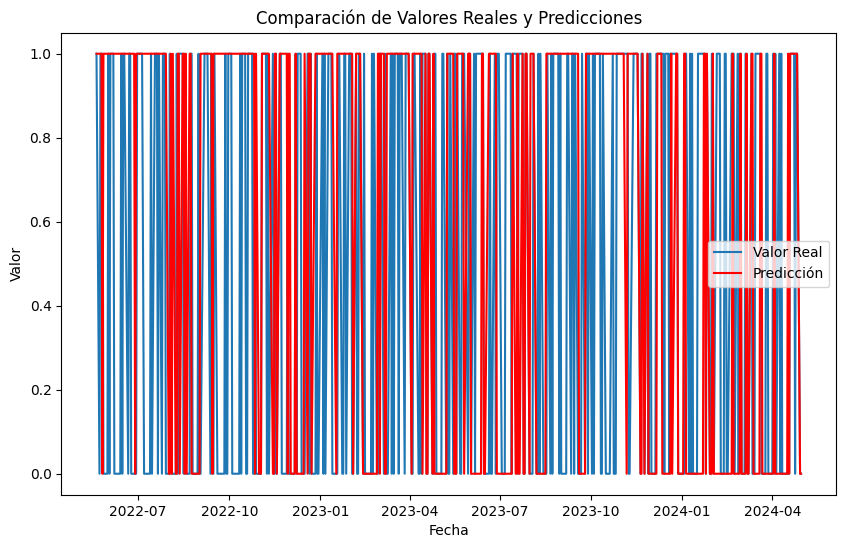

In [106]:
# Evaluar el mejor modelo
best_model.evaluate(test_generator)

# Obtener predicciones del mejor modelo
predictions = best_model.predict(test_generator)

# Aplicar el umbral para convertir las predicciones a 0 y 1
predictions_binary = (predictions > 0.5).astype(int)

# Ajustar la longitud de Y_test_LSTM para que coincida con las predicciones
Y_test_adjusted = Y_test_LSTM[14:].values

# Crear un DataFrame para comparar predicciones y valores reales
results_df = pd.DataFrame({
    'Fecha': Y_test_LSTM.index[14:],  # Ajustar la longitud del índice
    'Valor_Real': Y_test_adjusted,
    'Predicción': predictions_binary.flatten()
})

# Guardar los resultados en un archivo CSV
filename = f'LTSM_opt_forecast_results_{fecha_inicio}_{test_size_Control}.csv'
results_df.to_csv(filename, index=False)

# Mostrar los resultados
print(results_df)

# Graficar los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['Fecha'], results_df['Valor_Real'], label='Valor Real')
plt.plot(results_df['Fecha'], results_df['Predicción'], label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de Valores Reales y Predicciones')
plt.legend()
plt.show()


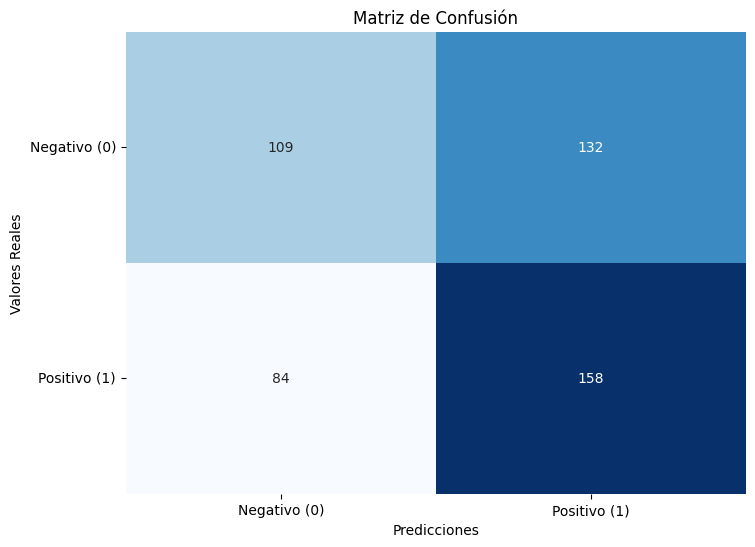

In [107]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula la matriz de confusión usando las predicciones ajustadas y los valores reales
conf_matrix = confusion_matrix(Y_test_adjusted, predictions_binary)

# Visualiza la matriz de confusión con Seaborn para una representación más clara
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.xticks([0.5, 1.5], ['Negativo (0)', 'Positivo (1)'], rotation=0)
plt.yticks([0.5, 1.5], ['Negativo (0)', 'Positivo (1)'], rotation=0, va='center')
plt.show()


In [108]:
# Asumiendo que 'results_df' ya está definido y contiene las columnas 'Valor_Real' y 'Predicción'

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(results_df['Valor_Real'], results_df['Predicción'])

# Calcular métricas de desempeño
accuracy = accuracy_score(results_df['Valor_Real'], results_df['Predicción'])
precision = precision_score(results_df['Valor_Real'], results_df['Predicción'])
recall = recall_score(results_df['Valor_Real'], results_df['Predicción'])
f1 = f1_score(results_df['Valor_Real'], results_df['Predicción'])

# Imprimir los resultados
print("Matriz de Confusión:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensibilidad): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Opcional: Calcular la especificidad
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
specificity = TN / (TN + FP)
print(f"Especificidad: {specificity:.4f}")


Matriz de Confusión:
[[109 132]
 [ 84 158]]
Accuracy: 0.5528
Precision: 0.5448
Recall (Sensibilidad): 0.6529
F1-Score: 0.5940
Especificidad: 0.4523


In [109]:
from sklearn.preprocessing import StandardScaler
from joblib import dump
import os

# Create the directory if it does not exis
save_path = 'C:/Users/lgarn/OneDrive/Documentos/DS Master+/TFM/LSTM all variables'

os.makedirs(save_path, exist_ok=True)

try:
    scaler = StandardScaler()
    X_train_scaled_LSTM = scaler.fit_transform(X_train_LSTM)
    # Save the scaler
    dump(scaler, os.path.join(save_path, 'scaler.joblib'))
    print("Scaler saved successfully.")
except Exception as e:
    print(f"An error occurred: {e}")



Scaler saved successfully.


In [110]:
print(best_batch_size)

16.0
